# Well-log Facies Classification using Machine Learning

Objective: This project demonstrates use of a popular machine learning algorithm called SVM to predict rock facies from well log measurements data. 

Dataset: The dataset used in the project is from The University of Kansas (http://www.people.ku.edu/~gbohling/EECS833/). The dataset includes wireline log data from nine wells that have been labeled with a rock facies type based on oberservation of core.  

Method: The dataset is used to train a support vector machine (SVM) to classify facies types. SVMs are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall (wikipedia). For this project SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/svm.html) is used.

Exploration: The training data from 9 wells is loaded using [pandas](https://pandas.pydata.org/). Cross plots are created to observe at the variation within the data for a few wells.  

Pre-processing and Feature Extraction: Samples that have missing features (incomplete entries) are dropped. The features is scaled to have zero mean and unit variance and split into training set and test set.

Classification: SVM classifer is used to train using the training data and then used to make predictions on the testing data.

## Exploration

The training data is contained in the file `facies_vectors.csv`.  The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).

In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import svm
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [80]:
training_data = pd.read_csv('facies_vectors.csv')
training_data.head(10)

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
5,3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894
6,3,A1 SH,SHRIMPLIN,2796.0,73.72,0.630,15.6,13.930,3.7,1,0.872
7,3,A1 SH,SHRIMPLIN,2796.5,75.65,0.625,16.5,13.920,3.5,1,0.830
8,3,A1 SH,SHRIMPLIN,2797.0,73.79,0.624,16.2,13.980,3.4,1,0.809
9,3,A1 SH,SHRIMPLIN,2797.5,76.89,0.615,16.9,14.220,3.5,1,0.787


The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE. Samples which do not have PE shall be dropped to reduce classification error.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete rock facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies are not discrete, and gradually blend into one another. Misclassification within neighboring facies (listed below) can be expected to occur.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |sandstone| 2
2 |coarse siltstone| 1,3
3 |fine siltstone| 2
4 |siltstone and shale| 5
5 |mudstone| 4,6
6 |wackestone| 5,7
7 |dolomite| 6,8
8 |grainstone| 6,7,9
9 |bafflestone| 7,8 

For more information, visit (https://library.seg.org/doi/full/10.1190/tle35100906.1)

For plotting the well data, a color map is defined so that the facies are represented by consistent color in all the plots.

In [81]:
facies_color_map = {}

facies_classes = ['S', 'CS', 'FS', 'SS', 'M','W', 'D','G', 'B']

facies_colors_map = ['#F5B075','#F4D03F','#AED6F1','#6E2C89','#1B4F99', '#196F3D','#2E86C1', '#A569BD','#DC7600']

for index, label in enumerate(facies_classes):
    facies_color_map[label] = facies_colors_map[index]

training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: facies_classes[ row['Facies'] -1], axis=1)
training_data.describe()
#statistical description of data

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Note that PE count value is less than the rest of the features as it is missing in some samples. These samples shall be dropped.

In [82]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

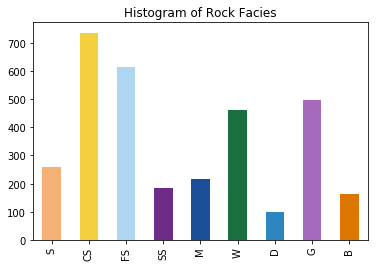

In [83]:
facies_count = training_data['Facies'].value_counts().sort_index()
facies_count.index = facies_classes

facies_count.plot(kind='bar',color=facies_colors_map, title='Histogram of Rock Facies')

Plots are created for well log features and facies labels. The functions for plots are derived from Alessandro Amato del Monte's [tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [84]:
def facies_log_plot(logs, facies_colors_map):
    #sort logs by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors_map[0:len(facies_colors_map)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '0.5')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='r')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='black')
    ax[4].plot(logs.PE, logs.Depth, '-', color='g')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' S ', ' CS ', ' FS ', ' SS ', ' M ',' W ', ' D ',' G ', ' B ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

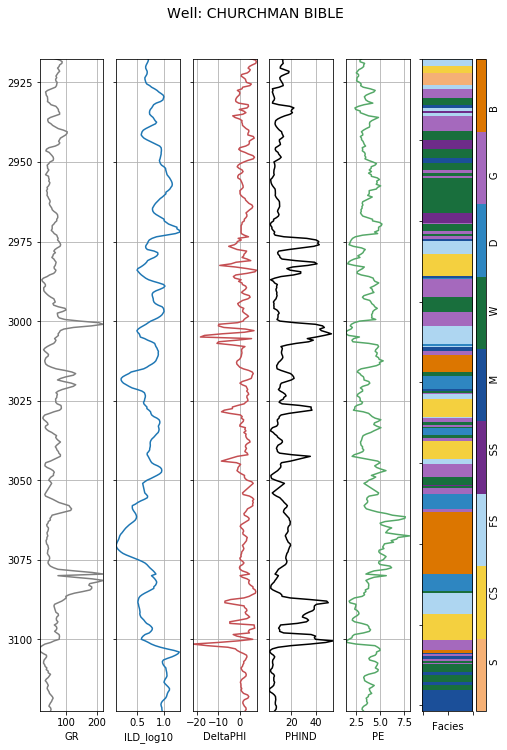

In [85]:
facies_log_plot(training_data[training_data['Well Name'] == 'CHURCHMAN BIBLE'],facies_colors_map)

A histogram of the number of training data samples for each facies class is plotted.

To create crossplots, scatter matrices are used to visualize variation between the 5 wireline log features. [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) is used to create scatter matrices. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies class using the same colour map.

c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


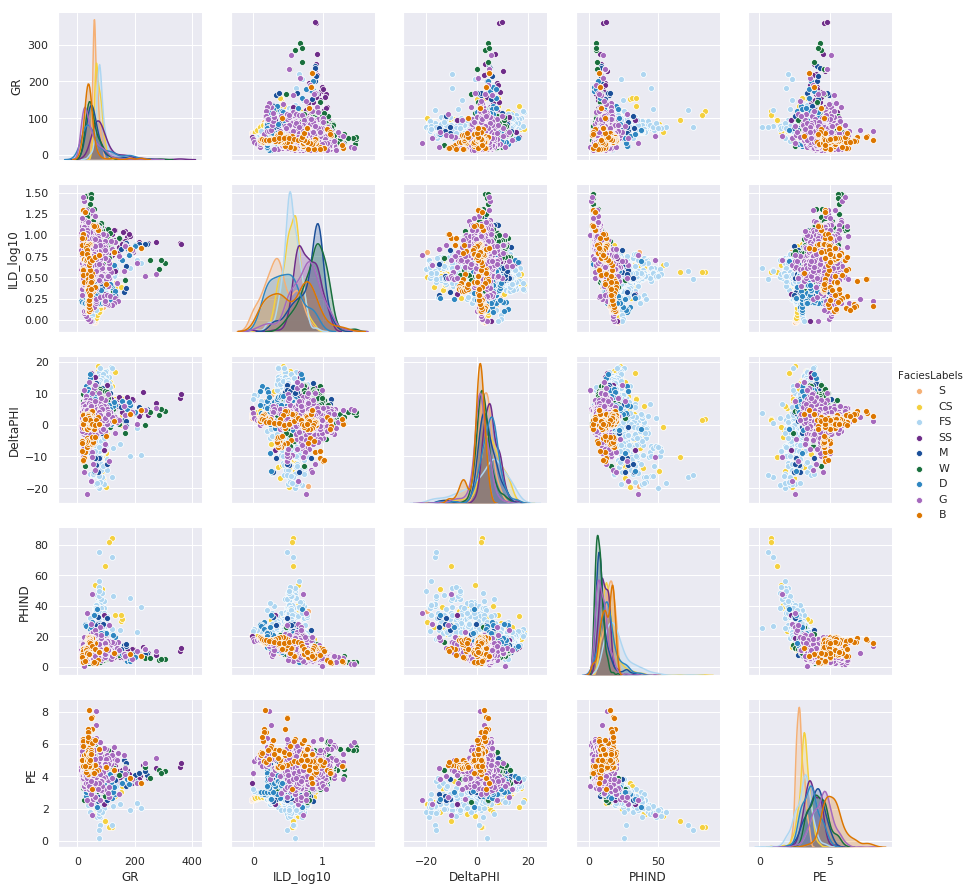

In [86]:
inline_crossplot = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),hue='FaciesLabels', 
             palette=facies_color_map,hue_order=list(facies_classes))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_crossplot)

## Pre-processing and Classification

Features required to perform facies classification are extracted which include the five wireline values and two geologic constraining variables. The class labels are the list of facies that correspond to each training data sample.
Using built-in scikit learn functions to have zero mean and unit variance for all feature vectors for better training of SVM classifier before splitting the data into training and testing set.

In [87]:
facies_labels = training_data['Facies'].values

feature_vector = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)

scaler = preprocessing.StandardScaler().fit(feature_vector)
scaled_feature_vector = scaler.transform(feature_vector)

X_train, X_test, y_train, y_test = train_test_split(scaled_feature_vector, facies_labels, test_size=0.2, random_state=42)

c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Classification

SVM is used for classification. 

In [88]:
clf = svm.SVC(C=10, gamma=1) 
#training the classifier
clf.fit(X_train,y_train)
#making predictions on testing data
predicted_labels = clf.predict(X_test)

Confusion matrix is created to judge the accuracy of the classifier

In [89]:
facies_confusion_matrix = confusion_matrix(predicted_labels, y_test)
display_cm(facies_confusion_matrix, facies_classes, display_metrics=True, hide_zeros=True)

     Pred     S    CS    FS    SS     M     W     D     G     B Total
     True
        S    36     7     2                                        45
       CS    10   126    23                             1         160
       FS          19    98     1     2                 6         126
       SS                 1    24     4     9           3          41
        M                       1    27     5     1     1          35
        W           1     1     1    10    74          12          99
        D                                        12                12
        G                 1     1     4    12     8    70          96
        B                                         1     1    31    33

Precision  0.78  0.82  0.78  0.86  0.57  0.74  0.55  0.74  1.00  0.78
   Recall  0.80  0.79  0.78  0.59  0.77  0.75  1.00  0.73  0.94  0.77
       F1  0.79  0.81  0.78  0.70  0.66  0.74  0.71  0.74  0.97  0.77


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.

In [90]:
correct_count = 0.
num_classes = facies_confusion_matrix.shape[0]
for x in np.arange(num_classes):
    correct_count += facies_confusion_matrix[x][x]
    accuracy = correct_count/sum(sum(facies_confusion_matrix))

Another measure of how well the classifier performs is to check if the predicted neighbouring features match the misclassified facies label as shown below.

In [91]:
neighbour_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

nh_correct = 0.
for x in np.arange(num_classes):
    nh_correct += facies_confusion_matrix[x][x]
    for y in neighbour_facies[x]:
        nh_correct += facies_confusion_matrix[x][y]
    neighbour_accuracy = nh_correct / sum(sum(facies_confusion_matrix))

In [92]:
print('Facies classification accuracy = %f' % accuracy)
print('Adjacent facies classification accuracy = %f' % neighbour_accuracy)

Facies classification accuracy = 0.769706
Adjacent facies classification accuracy = 0.944359


## Using the classifier model with unlabelled data

This dataset has the same sort of as the training data but it does not have facies labels.  It is named called `validation_data_nofacies`.

In [93]:
unlabelled_data = pd.read_csv('validation_data_nofacies.csv')
unlabelled_data['Well Name'] = unlabelled_data['Well Name'].astype('category')
unlabelled_data_features = unlabelled_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

X_validation = scaler.transform(unlabelled_data_features)

#predict facies of unclassified data
y_validation = clf.predict(X_validation)
unlabelled_data['Facies'] = y_validation
unlabelled_data.head(10)

c:\users\rzain\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,3
5,A1 SH,STUART,2810.5,73.955,0.667,6.9,12.25,3.086,1,0.889,3
6,A1 SH,STUART,2811.0,77.962,0.674,6.5,12.45,3.092,1,0.867,3
7,A1 SH,STUART,2811.5,83.894,0.667,6.3,12.65,3.123,1,0.844,2
8,A1 SH,STUART,2812.0,84.424,0.653,6.7,13.05,3.121,1,0.822,2
9,A1 SH,STUART,2812.5,83.160,0.642,7.3,12.95,3.127,1,0.800,2


## References

Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Alaudah Y, Michalowicz P, Alfarraj M, AlRegib G, 2019. A Machine Learning Benchmark for Facies Classification. [pdf](https://arxiv.org/abs/1901.07659)